In [1]:
import sys
sys.path.append('/home/shmoon/shmoon/lib/python3.6/site-packages')

In [2]:
import tensorflow as tf

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

* Oxford-IIIT Pets dataset download

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

이미지를 뒤집는 간단한 확장  
영상이 [0,1] 로 정규화  
분할 마스크의 픽셀에 {1,2,3} 이라는 레이블  

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

데이터 세트에는 이미 필요한 몫의 시험과 훈련이 포함되어 있기 때문에 동일한 분할을 계속 사용

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

이미지 예제와 데이터 세트에서 대응하는 마스크를 보도록 하자

In [11]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

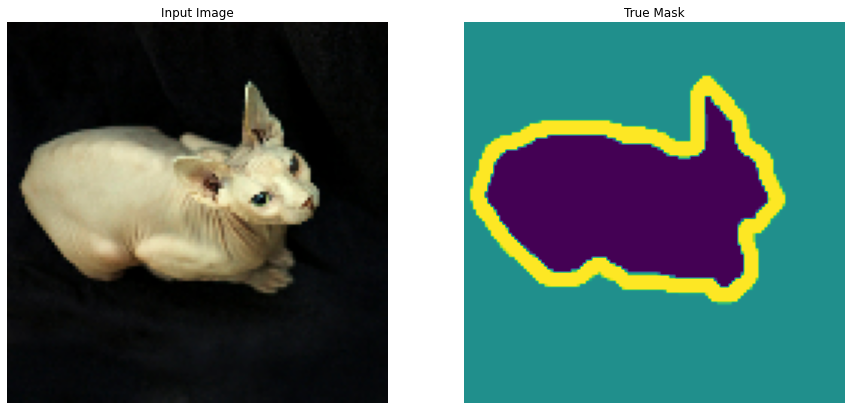

In [12]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Model 정의

3개의 채널을 출력하는 이유: 픽셀당 3개의 가능한 라벨이 존재  
각 화소가 세 개의 class로 분류되는 다중 분류라고 생각하기

In [13]:
OUTPUT_CHANNELS = 3

인코더는 미리 훈련된 MobileNetV2 모델이 될 것이며  
tf.keras.applications에서 사용될 준비가 될 것이다  
인코더는 모델의 중간 층에서 나오는 특정 출력으로 구성  
인코더는 교육 과정 중에 학습되지 않는다는 점을 유의  

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 이 층들의 활성화를 이용
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]

layers = [base_model.get_layer(name).output for name in layer_names]

# 특징 추출 모델
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

디코더/업샘플러는 Tensorflow 예제에서 구현된 일련의 업샘플 블록

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3)
]

In [16]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs
    
    # model 을 통해 downsampling
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # 건너뛰기 연결을 통해 upsampling, and then setting
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # 이 모델의 마지막 층
    last = tf.keras.layers.Conv2DTranspose(
    output_channels, 3, strides=2,
    padding='same') # 64 * 64 -> 128 * 128
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

Model Train

사용되고 있는 손실 함수 (loss function) -> loss.sparse_categorical_crossentropy  
why? network가 멀티클래스 예측과 마찬가지로 픽셀마다 레이블을 할당하려고 하기 때문  
실제 분할 마스크에서 각 픽셀은 {0,1,2} 를 가짐  
이곳의 네트워크는 세 개의 채널을 출력  
각 채널은 클래스를 예측하는 방법을 배우려고 하는 중  
loss.spares_categorical_crossentropy는 그러한 사항에 맞는 손실  
네트워크의 출력을 사용하여 픽셀에 할당된 레이블 -> 가장 높은 값을 가짐  
-> create_mask 가 하는 일

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

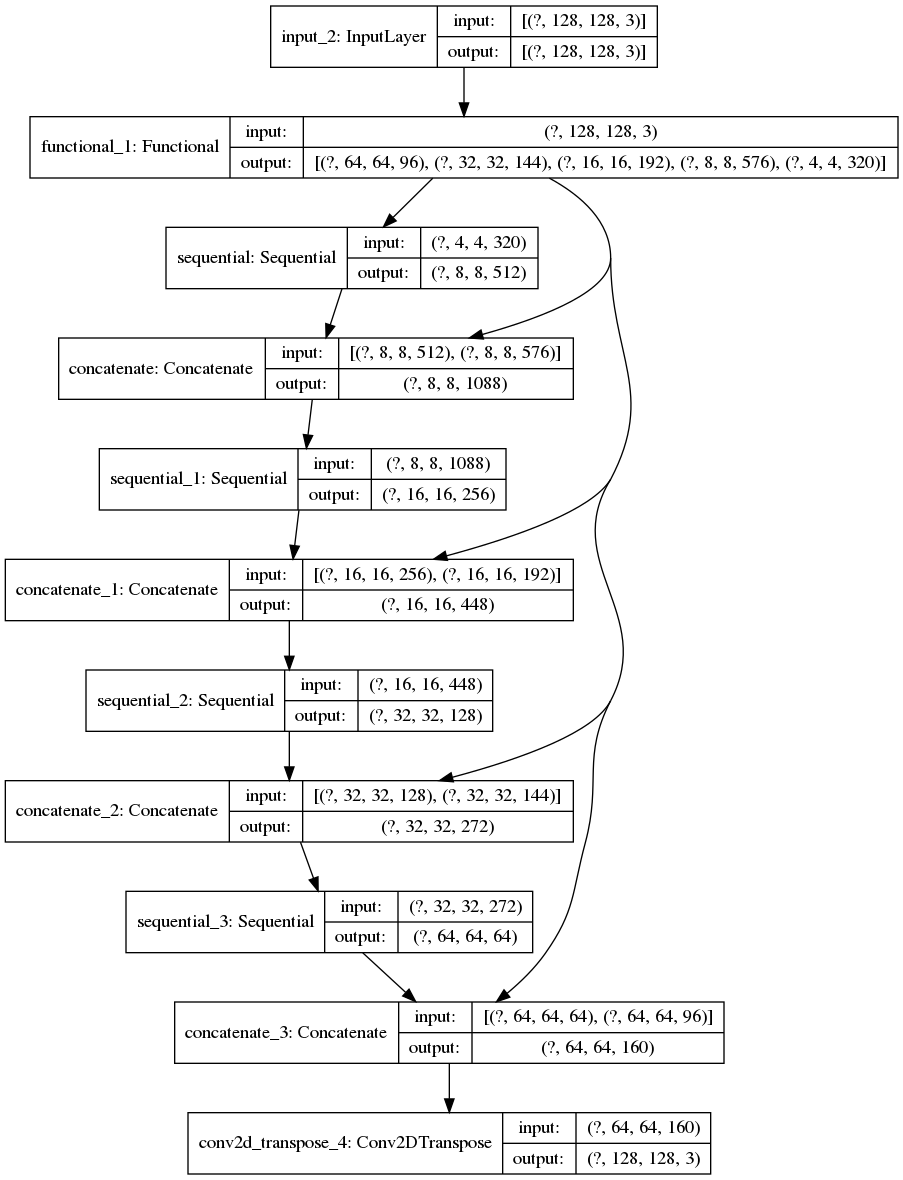

In [18]:
tf.keras.utils.plot_model(model, b
                          show_shapes=True)

Before Train

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [42]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])

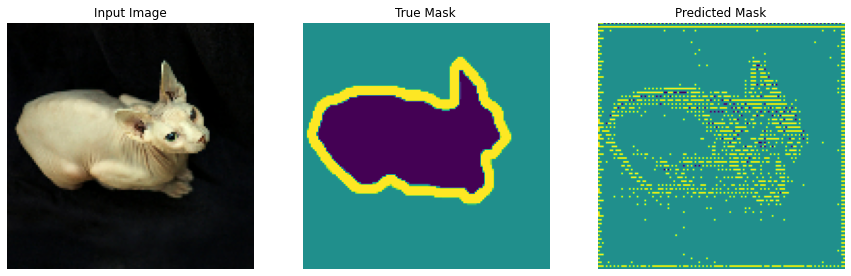

In [43]:
show_predictions()

Call Back Function

In [44]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\n prediction example after epoch {}\n'.format(epoch+1))

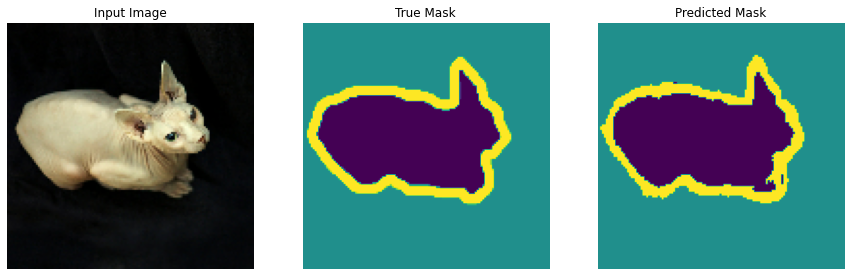


 prediction example after epoch 20

57/57 [==============================] - 4s 69ms/step - loss: 0.1369 - accuracy: 0.9375


In [47]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples

model_history = model.fit(train_dataset, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_dataset,
                         callbacks=[DisplayCallback()])